## Implementing BERT with SNGP

In [4]:
!pip install tensorflow_text==2.7.3

  Using cached tensorflow_text-2.7.3-cp38-cp38-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
  Using cached tensorflow-2.7.1-cp38-cp38-manylinux2010_x86_64.whl (495.1 MB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
  Using cached libclang-13.0.0-py2.py3-none-manylinux1_x86_64.whl (14.5 MB)
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.2
    Uninstalling tensorflow-2.6.2:
      Successfully uninstalled tensorflow-2.6.2
ERROR: pip's dependency resolver does not cur

In [5]:
!pip install -U tf-models-official==2.7.0

  Using cached tf_models_official-2.7.0-py2.py3-none-any.whl (1.8 MB)
  Using cached pycocotools-2.0.4-cp38-cp38-linux_x86_64.whl
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached google_api_python_client-2.37.0-py2.py3-none-any.whl (8.1 MB)
  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached Cython-0.29.28-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Using cached sentencepiece-0.1.96-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached tensorflow_datasets-4.5.2-py3-none-any.whl (4.2 MB)
  Using cached tensorflow_addons-0.16.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Using cached tensorflow_model_optimization-0.7.1-py2.py3-none-any.whl (234 kB)
  Using cached sacrebleu-2.0.0-py3-none-any.whl (90 kB)
  Using cached py_cpuinfo-8.0.0-py3-none-any.whl
  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached gin_config-0.5.0-py3-none-any.whl (61 kB)
  

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.metrics
import sklearn.calibration

import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import tensorflow as tf
import pandas as pd
import json

import official.nlp.modeling.layers as layers
import official.nlp.optimization as optimization

### Implement a standard BERT classifier following which classifies text

In [57]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [58]:
# Standard BERT model

PREPROCESS_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
MODEL_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

class BertClassifier(tf.keras.Model):
  def __init__(self, 
               num_classes=150, inner_dim=768, dropout_rate=0.1,
               **classifier_kwargs):
    
    super().__init__()
    self.classifier_kwargs = classifier_kwargs

    # Initiate the BERT encoder components.
    self.bert_preprocessor = hub.KerasLayer(PREPROCESS_HANDLE, name='preprocessing')
    self.bert_hidden_layer = hub.KerasLayer(MODEL_HANDLE, trainable=True, name='bert_encoder')

    # Defines the encoder and classification layers.
    self.bert_encoder = self.make_bert_encoder()
    self.classifier = self.make_classification_head(num_classes, inner_dim, dropout_rate)

  def make_bert_encoder(self):
    text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = self.bert_preprocessor(text_inputs)
    encoder_outputs = self.bert_hidden_layer(encoder_inputs)
    return tf.keras.Model(text_inputs, encoder_outputs)

  def make_classification_head(self, num_classes, inner_dim, dropout_rate):
    return layers.ClassificationHead(
        num_classes=num_classes, 
        inner_dim=inner_dim,
        dropout_rate=dropout_rate,
        **self.classifier_kwargs)

  def call(self, inputs, **kwargs):
    encoder_outputs = self.bert_encoder(inputs)
    classifier_inputs = encoder_outputs['sequence_output']
    return self.classifier(classifier_inputs, **kwargs)


### Build SNGP model

To implement a BERT-SNGP model designed by Google researchers

In [59]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the begining of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [60]:
class SNGPBertClassifier(BertClassifier):

  def make_classification_head(self, num_classes, inner_dim, dropout_rate):
    return layers.GaussianProcessClassificationHead(
        num_classes=num_classes, 
        inner_dim=inner_dim,
        dropout_rate=dropout_rate,
        gp_cov_momentum=-1,
        temperature=30.,
        **self.classifier_kwargs)

  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs['callbacks'] = list(kwargs.get('callbacks', []))
    kwargs['callbacks'].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

### Load train and test datasets

In [61]:
is_train = pd.read_json('is_train.json')
is_train.columns = ['question','intent']

is_test = pd.read_json('is_test.json')
is_test.columns = ['question','intent']

oos_test = pd.read_json('oos_test.json')
oos_test.columns = ['question','intent']

is_test.shape

(4500, 2)

Make the train and test data.

In [62]:
#Generate codes
is_data = is_train.append(is_test)
is_data.intent = pd.Categorical(is_data.intent)
is_data['code'] = is_data.intent.cat.codes

#in-scope evaluation data
is_test = is_data[15000:19500]

is_test_queries = is_test.question
is_test_labels = is_test.intent
is_test_codes = is_test.code

is_eval_data = (tf.convert_to_tensor(is_test_queries), tf.convert_to_tensor(is_test_codes))

is_train = is_data[0:15000]
is_train_queries = is_train.question
is_train_labels = is_train.intent
is_train_codes = is_train.code

training_ds_queries = tf.convert_to_tensor(is_train_queries)

training_ds_labels = tf.convert_to_tensor(is_train_codes)

In [63]:
is_test.shape

(4500, 3)

Create a OOD evaluation dataset. For this, combine the in-scope test data 'is_test' and out-of-scope 'oos_test' data. Assign label 0 for in-scope and label 1 for out-of-scope data

In [64]:
train_size = len(is_train)
test_size = len(is_test)
oos_size = len(oos_test)

# Combines the in-domain and out-of-domain test examples.
oos_queries= tf.concat([is_test['question'], oos_test['question']], axis=0)
oos_labels = tf.constant([0] * test_size + [1] * oos_size)

# Converts into a TF dataset.
oos_eval_dataset = tf.data.Dataset.from_tensor_slices(
    {"text": oos_queries, "label": oos_labels})

### Train and evaluate

In [65]:
TRAIN_EPOCHS = 4
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 256

In [66]:
#@title

def bert_optimizer(learning_rate, 
                   batch_size=TRAIN_BATCH_SIZE, epochs=TRAIN_EPOCHS, 
                   warmup_rate=0.1):
  """Creates an AdamWeightDecay optimizer with learning rate schedule."""
  train_data_size = train_size
  
  steps_per_epoch = int(train_data_size / batch_size)
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(warmup_rate * num_train_steps)  

  # Creates learning schedule.
  lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=num_train_steps,
      end_learning_rate=0.0)  
  
  return optimization.AdamWeightDecay(
      learning_rate=lr_schedule,
      weight_decay_rate=0.01,
      epsilon=1e-6,
      exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])

In [67]:
optimizer = bert_optimizer(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [68]:
fit_configs = dict(batch_size=TRAIN_BATCH_SIZE,
                   epochs=TRAIN_EPOCHS,
                   validation_batch_size=EVAL_BATCH_SIZE, 
                   validation_data=is_eval_data)

### Model 1 - Batch size of 32 & 3 epochs 

In [21]:
sngp_model = SNGPBertClassifier()
sngp_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
sngp_model.fit(training_ds_queries, training_ds_labels, **fit_configs)

Epoch 1/2
938/938 [==============================] - 481s 494ms/step - loss: 0.8704 - sparse_categorical_accuracy: 0.8241 - val_loss: 0.2888 - val_sparse_categorical_accuracy: 0.9473
Epoch 2/2
938/938 [==============================] - 464s 495ms/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.1979 - val_sparse_categorical_accuracy: 0.9598


### Model 2 - Batch size of 16 & 2 epochs 

In [46]:
sngp_model2 = SNGPBertClassifier()
sngp_model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
sngp_model2.fit(training_ds_queries, training_ds_labels, **fit_configs)

Epoch 1/3
938/938 [==============================] - 480s 495ms/step - loss: 0.9506 - sparse_categorical_accuracy: 0.8029 - val_loss: 0.3883 - val_sparse_categorical_accuracy: 0.9376
Epoch 2/3
938/938 [==============================] - 462s 493ms/step - loss: 0.0989 - sparse_categorical_accuracy: 0.9769 - val_loss: 0.2342 - val_sparse_categorical_accuracy: 0.9522
Epoch 3/3
938/938 [==============================] - 462s 493ms/step - loss: 0.0272 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.2013 - val_sparse_categorical_accuracy: 0.9598


### Model 3 - Batch size of 16 & 4 epochs 

In [69]:
sngp_model3 = SNGPBertClassifier()
sngp_model3.compile(optimizer=optimizer, loss=loss, metrics=metrics)
sngp_model3.fit(training_ds_queries, training_ds_labels, **fit_configs)

Epoch 1/4
938/938 [==============================] - 477s 493ms/step - loss: 0.9459 - sparse_categorical_accuracy: 0.8066 - val_loss: 0.3804 - val_sparse_categorical_accuracy: 0.9393
Epoch 2/4
938/938 [==============================] - 465s 496ms/step - loss: 0.1192 - sparse_categorical_accuracy: 0.9730 - val_loss: 0.2526 - val_sparse_categorical_accuracy: 0.9511
Epoch 3/4
938/938 [==============================] - 466s 497ms/step - loss: 0.0372 - sparse_categorical_accuracy: 0.9917 - val_loss: 0.2169 - val_sparse_categorical_accuracy: 0.9564
Epoch 4/4
938/938 [==============================] - 465s 496ms/step - loss: 0.0135 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.1992 - val_sparse_categorical_accuracy: 0.9629


### Evaluate OOD performance

Evaluate how well the model can detect the unfamiliar out-of-domain queries.

In [22]:


def oos_predict(model, ood_eval_dataset, **model_kwargs):
  oos_labels = []
  oos_probs = []

  ood_eval_dataset = ood_eval_dataset.batch(EVAL_BATCH_SIZE)
  for oos_batch in ood_eval_dataset:
    oos_text_batch = oos_batch["text"]
    oos_label_batch = oos_batch["label"] 

    pred_logits = model(oos_text_batch, **model_kwargs)
    pred_probs_all = tf.nn.softmax(pred_logits, axis=-1)
    pred_probs = tf.reduce_max(pred_probs_all, axis=-1)

    oos_labels.append(oos_label_batch)
    oos_probs.append(pred_probs)

  oos_probs = tf.concat(oos_probs, axis=0)
  oos_labels = tf.concat(oos_labels, axis=0) 

  return oos_probs, oos_labels

Computes the OOD probabilities as $1 - p(x)$, where $p(x)=softmax(logit(x))$ is the predictive probability.

In [25]:
sngp_probs, ood_labels = oos_predict(sngp_model, oos_eval_dataset)

In [70]:
sngp_probs2, ood_labels2 = oos_predict(sngp_model2, oos_eval_dataset)

In [71]:
sngp_probs3, ood_labels3 = oos_predict(sngp_model3, oos_eval_dataset)

In [72]:
ood_probs = 1 - sngp_probs
ood_probs2 = 1 - sngp_probs2
ood_probs3 = 1 - sngp_probs3

In [73]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

In [74]:
ood_uncertainty = ood_probs * (1 - ood_probs)
ood_uncertainty2 = ood_probs2 * (1 - ood_probs2)
ood_uncertainty3 = ood_probs3 * (1 - ood_probs3)

In [78]:
s1 = np.array(sngp_probs.numpy())
print(s1[3000])

0.98855245


In [79]:
s2 = np.array(sngp_probs2.numpy())
print(s2[2000])

0.99832803


In [80]:
s3 = np.array(sngp_probs3.numpy())
print(s3[1000])

0.9983203


### Compute the Area under precision-recall curve (AUPRC) for OOD probability v.s. OOD detection accuracy.

In [81]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(ood_labels, ood_probs)
precision2, recall2, _ = sklearn.metrics.precision_recall_curve(ood_labels2, ood_probs2)
precision3, recall3, _ = sklearn.metrics.precision_recall_curve(ood_labels3, ood_probs3)

In [ ]:
print((precision3)
print(recall3)

[0.23380874 0.23362956 0.23368421 ... 1.         1.         1.        ]
[1.    0.999 0.999 ... 0.002 0.001 0.   ]

In [6]:
sklearn.metrics.recall_score(oos_labels, ood_labels3, average='weighted')

1.0

In [7]:
sklearn.metrics.precision_score(oos_labels, ood_labels3, average='weighted')

1.0

In [33]:
auprc = sklearn.metrics.auc(recall, precision)
print(f'SNGP AUPRC: {auprc:.4f}')

SNGP AUPRC: 0.9026


In [82]:
auprc2 = sklearn.metrics.auc(recall2, precision2)
print(f'SNGP AUPRC 2: {auprc2:.4f}')

SNGP AUPRC 2: 0.8926


In [83]:
auprc3 = sklearn.metrics.auc(recall3, precision3)
print(f'SNGP AUPRC 3: {auprc3:.4f}')

SNGP AUPRC 3: 0.8926


In [84]:
prob_true, prob_pred = sklearn.calibration.calibration_curve(
    ood_labels, ood_probs, n_bins=10, strategy='quantile')

prob_true2, prob_pred2 = sklearn.calibration.calibration_curve(
    ood_labels2, ood_probs2, n_bins=10, strategy='quantile')

prob_true3, prob_pred3 = sklearn.calibration.calibration_curve(
    ood_labels3, ood_probs3, n_bins=10, strategy='quantile')

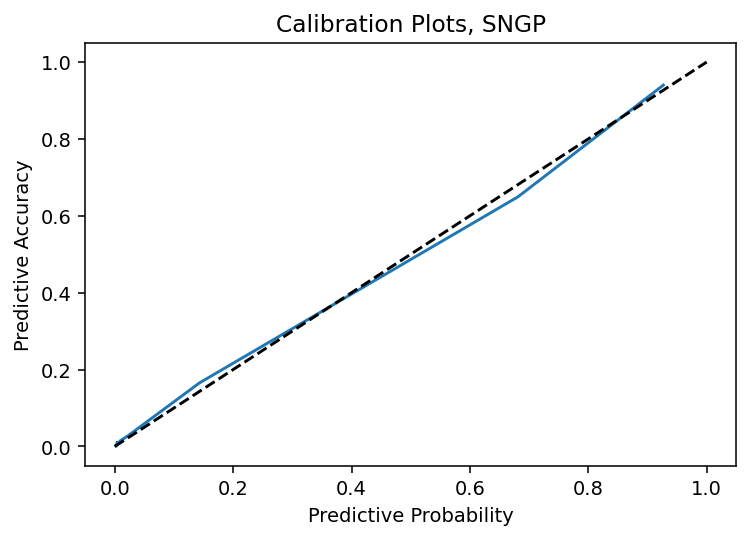

In [35]:
plt.plot(prob_pred, prob_true)

plt.plot([0., 1.], [0., 1.], c='k', linestyle="--")
plt.xlabel('Predictive Probability')
plt.ylabel('Predictive Accuracy')
plt.title('Calibration Plots, SNGP')

plt.show()

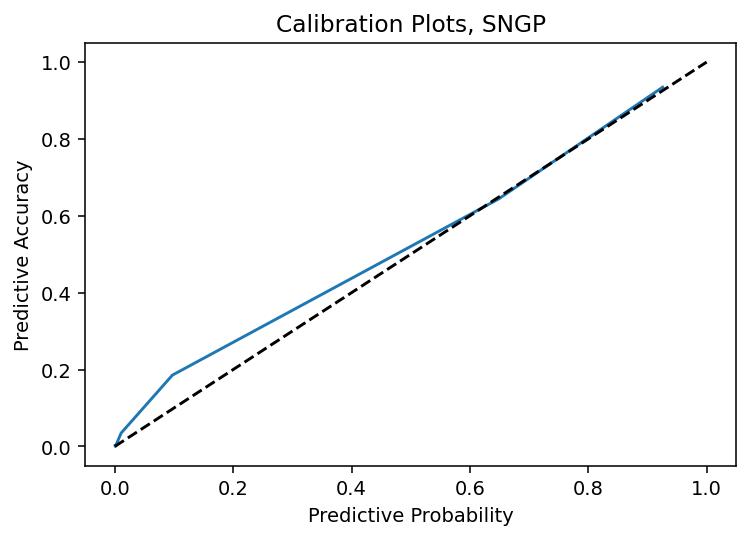

In [85]:
plt.plot(prob_pred2, prob_true2)

plt.plot([0., 1.], [0., 1.], c='k', linestyle="--")
plt.xlabel('Predictive Probability')
plt.ylabel('Predictive Accuracy')
plt.title('Calibration Plots, SNGP')

plt.show()

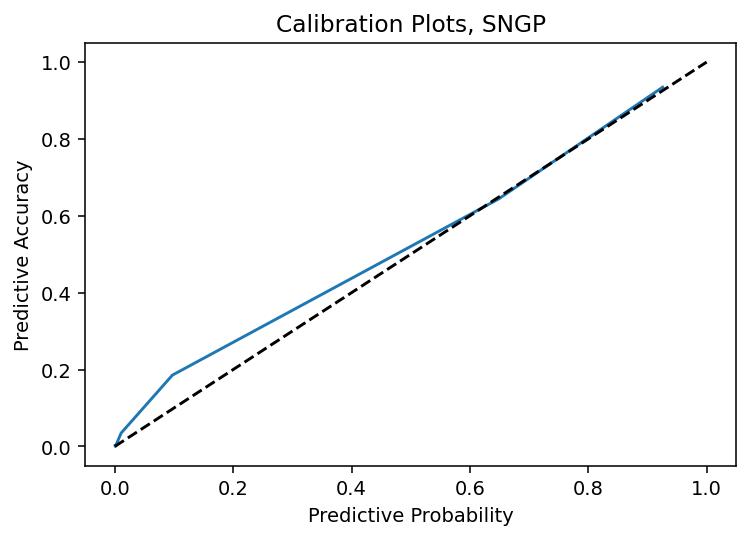

In [86]:
plt.plot(prob_pred3, prob_true3)

plt.plot([0., 1.], [0., 1.], c='k', linestyle="--")
plt.xlabel('Predictive Probability')
plt.ylabel('Predictive Accuracy')
plt.title('Calibration Plots, SNGP')

plt.show()

SNGP Model 1: ROC AUC=0.972
SNGP Model 2: ROC AUC=0.973
SNGP Model 3: ROC AUC=0.973


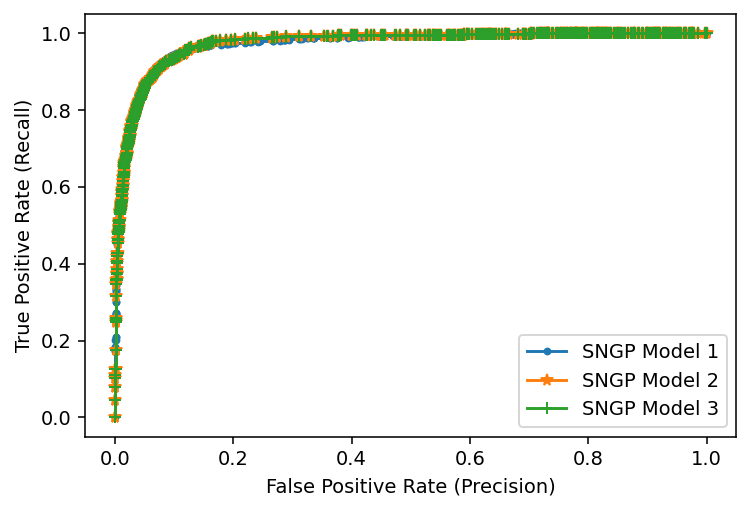

In [114]:
# calculate scores
auc1 = roc_auc_score(oos_labels, ood_probs)
auc2 = roc_auc_score(oos_labels, ood_probs2)
auc3 = roc_auc_score(oos_labels, ood_probs3)
# summarize scores
print('SNGP Model 1: ROC AUC=%.3f' % (auc1))
print('SNGP Model 2: ROC AUC=%.3f' % (auc2))
print('SNGP Model 3: ROC AUC=%.3f' % (auc3))
# calculate roc curves
fpr1, tpr1, _ = roc_curve(oos_labels, ood_probs)
fpr2, tpr2, _ = roc_curve(oos_labels, ood_probs2)
fpr3, tpr3, _ = roc_curve(oos_labels, ood_probs3)
# plot the roc curve for the model
pyplot.plot(fpr1, tpr1, marker='.', label='SNGP Model 1')
pyplot.plot(fpr2, tpr2, marker='*', label='SNGP Model 2')
pyplot.plot(fpr3, tpr3, marker='+', label='SNGP Model 3')
# axis labels
pyplot.xlabel('False Positive Rate (Precision)')
pyplot.ylabel('True Positive Rate (Recall)')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()